In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True,
)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
from torch.utils.data import DataLoader

loaders = {
    'train':DataLoader(train_data,
                         batch_size = 100,
                         shuffle=True,
                         num_workers=1),
    'test': DataLoader(test_data,
                        batch_size = 100,
                        shuffle=False,
                        num_workers=1),
}

In [6]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x117282850>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x117282880>}

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [8]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')


def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%)\n')

In [ ]:
for epoch in range(1, 11):
    train(epoch)
    test()  

Train Epoch: 1 [0/60000 (0%)]	2.314863
Train Epoch: 1 [2000/60000 (3%)]	2.228736
Train Epoch: 1 [4000/60000 (7%)]	1.656096
Train Epoch: 1 [6000/60000 (10%)]	1.262099
Train Epoch: 1 [8000/60000 (13%)]	1.037121
Train Epoch: 1 [10000/60000 (17%)]	0.859445
Train Epoch: 1 [12000/60000 (20%)]	0.809949
Train Epoch: 1 [14000/60000 (23%)]	0.598390
Train Epoch: 1 [16000/60000 (27%)]	0.567598
Train Epoch: 1 [18000/60000 (30%)]	0.691788
Train Epoch: 1 [20000/60000 (33%)]	0.409404
Train Epoch: 1 [22000/60000 (37%)]	0.601439
Train Epoch: 1 [24000/60000 (40%)]	0.554332
Train Epoch: 1 [26000/60000 (43%)]	0.447382
Train Epoch: 1 [28000/60000 (47%)]	0.568916
Train Epoch: 1 [30000/60000 (50%)]	0.703937
Train Epoch: 1 [32000/60000 (53%)]	0.666539
Train Epoch: 1 [34000/60000 (57%)]	0.419615
Train Epoch: 1 [36000/60000 (60%)]	0.560267
Train Epoch: 1 [38000/60000 (63%)]	0.479434
Train Epoch: 1 [40000/60000 (67%)]	0.421165
Train Epoch: 1 [42000/60000 (70%)]	0.335856
Train Epoch: 1 [44000/60000 (73%)]	0.376148

In [ ]:
# After training is complete, extract features and build FAISS index
# (Run this cell after all epochs are finished)

import faiss
import numpy as np
from torch.utils.data import DataLoader, Subset

# Optimized feature extraction: minimal memory, clear variables

def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            # Forward pass up to the penultimate layer
            x = F.relu(F.max_pool2d(model.conv1(data), 2))
            x = F.relu(F.max_pool2d(model.conv2_drop(model.conv2(x)), 2))
            x = x.view(-1, 320)
            x = F.relu(model.fc1(x))
            features.append(x.cpu().numpy())
            labels.append(target.cpu().numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Use the first 20 test images, batch size 2
larger_test_loader = DataLoader(Subset(test_data, range(20)), batch_size=2, shuffle=False)

# Clear previous variables to free memory
import gc
gc.collect()

features, labels = extract_features(model, larger_test_loader, device)

index = faiss.IndexFlatL2(features.shape[1])
index.add(features)

query = features[0].reshape(1, -1)
D, I = index.search(query, k=5)
print('Query label:', labels[0])
print('Nearest labels:', labels[I[0]])

Query label: 7
Nearest labels: [7 0 1 4 2]


Predicted Label: tensor([[2]])


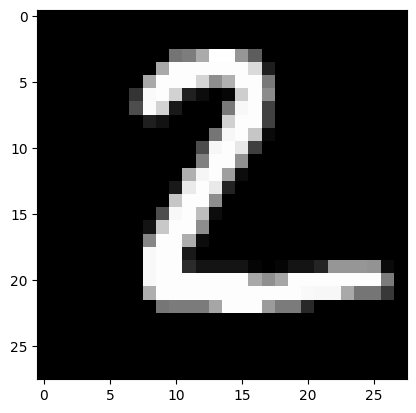

In [11]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[1]

data = data.unsqueeze(0).to(device)

output = model(data)
pred = output.argmax(dim=1, keepdim=True)

print(f'Predicted Label: {pred}')

image = data.squeeze().cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()